# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучите общую информацию. 

In [2]:
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib
import plotly.express as px

In [3]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')
pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

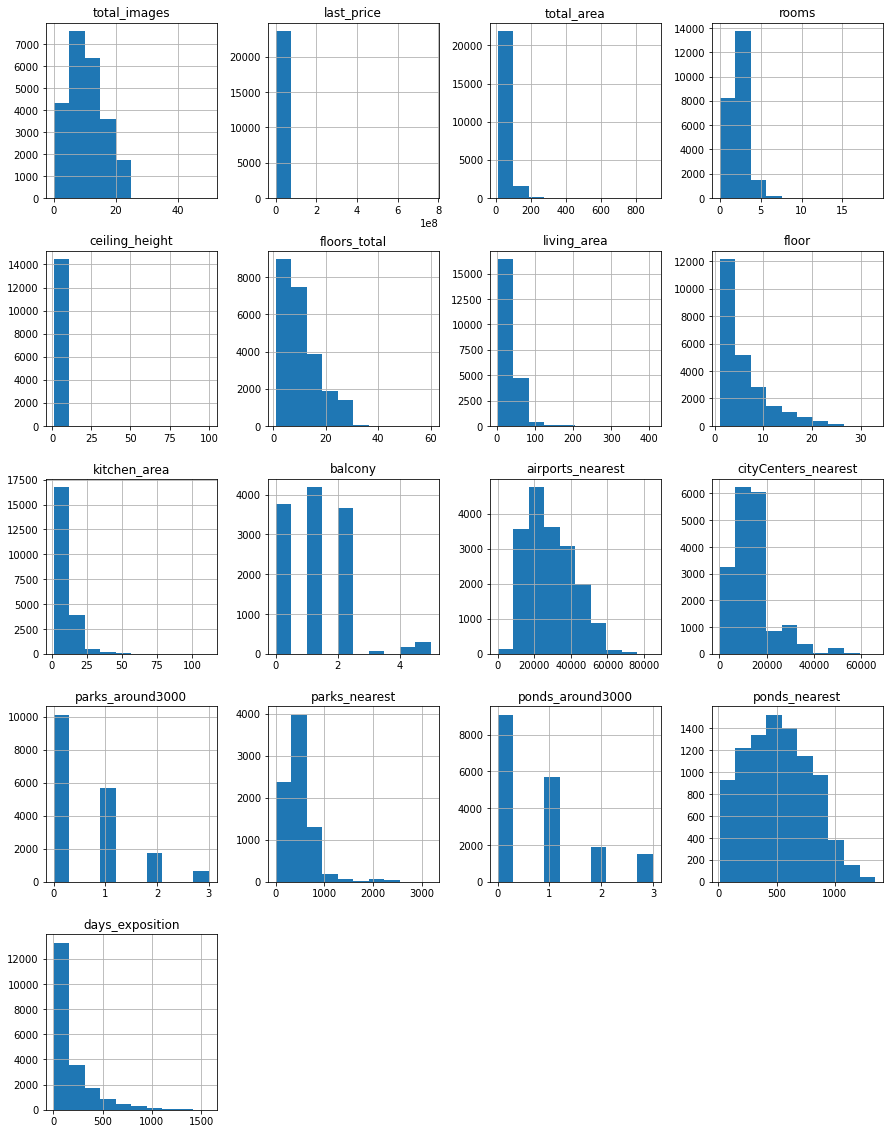

In [6]:
data.hist(figsize=(15, 20));

### Предобработка данных

In [7]:
data.isna().sum() #нахождение пропущенных значений 

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [8]:
data['balcony'].value_counts(dropna=False)

NaN    11519
1.0     4195
0.0     3758
2.0     3659
5.0      304
4.0      183
3.0       81
Name: balcony, dtype: int64

Если продавец не указал число балконов, то, скорее всего, в его квартире их нет. Такие пропуски правильно заменить на 0.

In [9]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].value_counts()

0.0    15277
1.0     4195
2.0     3659
5.0      304
4.0      183
3.0       81
Name: balcony, dtype: int64

In [10]:
#замена пропусков в is_apartment
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].value_counts(dropna=False)

False    23649
True        50
Name: is_apartment, dtype: int64

In [11]:
#заполнение пропусков медианным значением 'ceiling_height'
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['ceiling_height'].value_counts(dropna=False)

2.65     9871
2.50     3515
2.60     1646
2.70     1574
3.00     1112
         ... 
4.25        1
3.39        1
3.93        1
10.30       1
4.65        1
Name: ceiling_height, Length: 183, dtype: int64

In [12]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') # преобразование даты

In [13]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['floor'] = data['floor'].fillna(0)
data['floors_total'] = data['floors_total'].fillna(0)

In [14]:
# Преобразование к нужному типу данных (столбцы, чьи значения должны быть целочисленные):
data['last_price'] = data['last_price'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['floor'] = data['floor'].astype('int')
data['floors_total'] = data['floors_total'].astype('int')

#### Возможные причины пропусков 
Пропуски в графе 'balcony', могут означать, что в данных по недвижимости нет балконов, их следует заменить нулями. Большое количество пропусков свидетельствует о том, что их появление неслучайно и могло возникнуть из-за частичного заполнения данных или ошибки на этапе выгрузки. Пропуски в графе 'is_apartment' могут означать либо, что апартаменты появились относительно недавно либо с тем, что данные объекты недвижимости не являются апартаментами.
#### Изменения типов данных
Поля 'days_exposition', 'balcony', 'floor', 'floors_total', 'ponds_around3000', 'parks_around3000' следует изменить на целочисленные для удобства подсчета. 



In [27]:
#устранение неявных дубликатов
data['locality_name'].unique()

rename = ["пансионат ", "посёлок ", "поселок городского типа ", "поселок ", "деревня ",
         "посёлок городского типа ", "садовое товарищество ", "село ",
         "городской поселок ", "городской посёлок ", "поселок станции ",
         "посёлок при железнодорожной станции ", "городского типа ",
         "городской ", "при железнодорожной станции ", "станции ", "коттеджный ",
         "садоводческое некоммерческое товарищество"]

data['locality_name'] = data['locality_name'].replace(rename, '', regex=True)
data['locality_name'].sort_values().unique()


array([' Лесная Поляна', 'Агалатово', 'Александровская', 'Алексеевка',
       'Аннино', 'Аро', 'Барышево', 'Батово', 'Бегуницы', 'Белогорка',
       'Белоостров', 'Бокситогорск', 'Большая Вруда', 'Большая Ижора',
       'Большая Пустомержа', 'Большие Колпаны', 'Большое Рейзино',
       'Большой Сабск', 'Бор', 'Борисова Грива', 'Бугры', 'Будогощь',
       'Ваганово', 'Важины', 'Вартемяги', 'Вахнова Кара', 'Вещево',
       'Виллози', 'Вознесенье', 'Возрождение', 'Войсковицы', 'Войскорово',
       'Володарское', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Вырица', 'Выскатка', 'Высокоключевой', 'Высоцк', 'Гаврилово',
       'Гарболово', 'Гатчина', 'Гладкое', 'Глажево', 'Глебычево',
       'Глинка', 'Гончарово', 'Горбунки', 'Гостилицы', 'Громово',
       'Дзержинского', 'Дружная Горка', 'Дружноселье', 'Дубровка',
       'Елизаветино', 'Ефимовский', 'Жилгородок', 'Жилпосёлок', 'Житково',
       'Заводской', 'Заклинье', 'Заневка', 'Запорожское', 'Зеленогорск',
       'Зимитицы', 'Ив

In [28]:
type(data['locality_name'])

pandas.core.series.Series

In [16]:
data.ceiling_height.sort_values().unique() #уникальные значения высоты потолков

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

Вывод по данным:
при выводе данных можно увидеть аномальные значения - длина потолков более 20 метров, вероятно истиные значения меньше в 10 раз, а также видно аномально маленькую высоту потолков до 2 метров, такое может быть едва ли.

In [17]:
# Деление на 10 значений высоты потолка, которые больше 20 метров
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] = data['ceiling_height'] / 10

In [18]:
# Убираем аномально большие значения - более десяти метров
data.drop(data[data.ceiling_height > 10].index, inplace=True)

In [19]:
# Убираем аномально малые значения - менее двух с половиной метров
data.drop(data[data.ceiling_height < 2.5].index, inplace=True)

In [20]:
data['ceiling_height'].unique()

array([ 2.7 ,  2.65,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  3.2 ,  2.61,  3.25,  3.45,  2.77,
        2.85,  2.64,  2.57,  4.15,  3.5 ,  3.3 ,  2.71,  4.  ,  2.73,
        2.84,  3.1 ,  3.4 ,  3.06,  2.72,  2.54,  2.51,  2.78,  2.76,
        2.58,  3.7 ,  2.52,  5.2 ,  2.87,  2.66,  2.59,  3.6 ,  2.92,
        3.11,  3.13,  3.8 ,  3.15,  3.55,  3.16,  3.62,  3.12,  2.53,
        2.74,  2.96,  5.3 ,  5.  ,  2.79,  2.95,  4.06,  2.94,  3.82,
        3.54,  3.53,  2.83,  4.7 ,  3.38,  3.01,  5.6 ,  3.65,  3.9 ,
        3.18,  3.35,  3.57,  2.62,  2.82,  3.98,  2.63,  3.83,  3.52,
        3.95,  3.75,  2.88,  3.67,  3.87,  3.66,  3.85,  3.86,  4.19,
        3.24,  4.8 ,  4.5 ,  4.2 ,  3.36,  3.08,  3.68,  3.07,  3.37,
        3.09,  8.  ,  3.26,  3.34,  2.81,  3.44,  2.97,  3.14,  4.37,
        2.68,  3.22,  3.27,  4.1 ,  2.93,  3.46,  3.47,  3.33,  3.63,
        3.32,  8.3 ,  2.98,  2.86,  3.17,  4.4 ,  3.28,  3.04,  4.45,
        5.5 ,  3.84,

Выше изображен массив уникальньных значений поля 'ceiling_height' после восстановлений от аномалий и искажений, а так же после выброса редких и выбивающихщся значений.

In [21]:
# Площадь  более 250 м можно считать выбросами, отбросим.
data = data.loc[data['total_area'] <= 250]

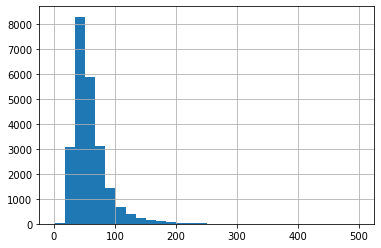

In [22]:
data['total_area'].hist(bins=30,  range=(1, 500))
plt.show()

Не забываем про богачей и их хоромы, поэтому посчитаем что 250 это ещё норма)

In [23]:
print('Квартир стоимостью меньше 1.000.000:', data.query('last_price < 1e+06')['last_price'].count())
print('Квартир стоимостью больше 100.000.000:', data.query('last_price > 1e+08')['last_price'].count())
data.drop(index=data.query('last_price > 1e+08').index,inplace=True) # Удаляем, что дороже 100 миллионов 


Квартир стоимостью меньше 1.000.000: 225
Квартир стоимостью больше 100.000.000: 14


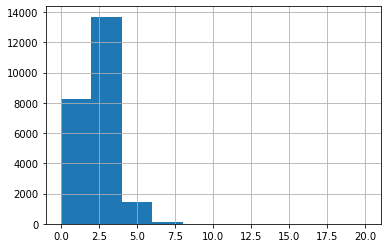

In [24]:
# Аномалии по комнатам
data['rooms'].hist(range=(0, 20))
plt.show()

Будет считать, что 6 комнат и более - ненормально, отбросим

In [25]:
# Уберем если их больше 6
data = data.loc[data['rooms'] < 6]

### Посчитайте и добавьте в таблицу новые столбцы

#### Добавление в таблицу новых столбцов со следующими параметрами:
- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [25]:
data['square_meter'] = data['last_price'] / data['total_area']# получение цены квадратного метра путем деления цены квартиры на ее прощадь

In [26]:
data['day_of_week'] = pd.DatetimeIndex(data['first_day_exposition']).weekday

In [27]:
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month

In [28]:
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

In [29]:
data['day_of_week'].unique() # получаем все возможные варианты дней недели от 0 до 6

array([3, 1, 4, 0, 2, 6, 5])

In [30]:
# определение типа этажей квартиры
def type_of_floor(i):
    if i['floor'] == 1:
        return 'Первый'
    if i['floor'] == i['floors_total']:
        return 'Последний'
    else:
        return 'Другой'

In [31]:
data['type_of_floor'] = data.apply(type_of_floor, axis = 1)

In [32]:
data['distance_to_the_city_center_in_kilometers'] = round(data['cityCenters_nearest'] / 1000) #округленное расстояние до центра города 

### Проведите исследовательский анализ данных

#### Проведение исследовательского анализа данных:
Изучение следующих параметров объектов:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

In [33]:
print(data['total_area'].describe())
print()
print(data.total_area.value_counts())

count    23362.000000
mean        58.250842
std         27.125996
min         12.000000
25%         40.000000
50%         51.800000
75%         68.800000
max        250.000000
Name: total_area, dtype: float64

45.00     415
42.00     381
60.00     345
31.00     345
44.00     344
         ... 
37.65       1
33.17       1
127.30      1
167.10      1
55.06       1
Name: total_area, Length: 2029, dtype: int64


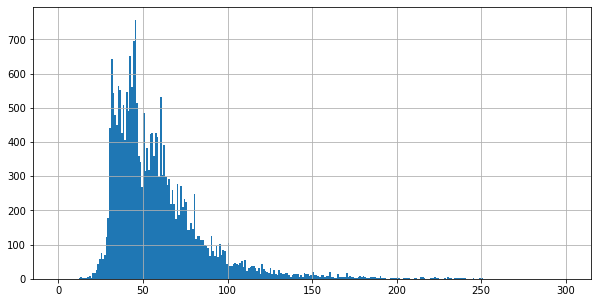

In [34]:
data.total_area.hist(bins=300, range = (0,300), figsize = (10,5)); # гистограмма по общей площади

По гистограмме можно сделать вывод, что большая часть жилья, выставленного на продажу находится в интервале до 150 м2. А наиболее значимая часть расположена в промежутке от 20 до 80 м2.

In [35]:
print(data.living_area.describe())
print()
print(data.living_area.value_counts())

count    21492.000000
mean        33.212448
std         17.452468
min          2.000000
25%         18.600000
50%         30.000000
75%         42.000000
max        200.000000
Name: living_area, dtype: float64

18.000000    880
17.000000    673
30.000000    597
16.000000    485
20.000000    479
            ... 
98.900000      1
32.020000      1
17.030000      1
29.599998      1
16.740000      1
Name: living_area, Length: 1654, dtype: int64


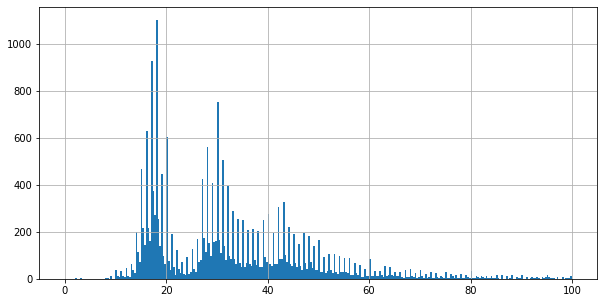

In [36]:
data.living_area.hist(bins=300, range = (0,100), figsize = (10,5)); # гистограмма жилой площади в квадратных метрах (м²)

In [37]:
print(data.kitchen_area.describe())
print()
print(data.kitchen_area.value_counts())

count    21124.000000
mean        10.414617
std          5.478684
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

6.00     1290
10.00    1257
8.00     1109
9.00     1096
7.00     1056
         ... 
7.12        1
13.73       1
14.74       1
13.41       1
16.74       1
Name: kitchen_area, Length: 943, dtype: int64


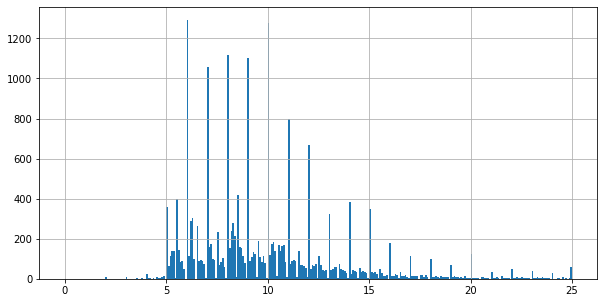

In [38]:
data.kitchen_area.hist(bins = 300, range = (0, 25), figsize = (10,5));

Пик распределение площадей кухонь находится от 5 до 15 м2.

In [39]:
print(data.last_price.describe())
print()
print(data.last_price.value_counts())

count    2.336200e+04
mean     6.026500e+06
std      5.621847e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.699000e+06
max      9.800000e+07
Name: last_price, dtype: float64

4500000     342
3500000     291
4300000     260
4000000     259
4200000     258
           ... 
5535000       1
26391824      1
8353000       1
7501000       1
11615600      1
Name: last_price, Length: 2879, dtype: int64


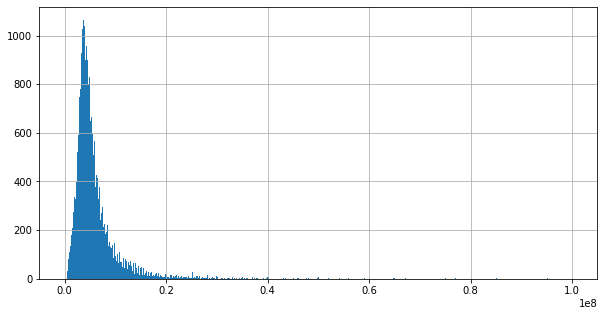

In [40]:
data.last_price.hist(bins = 500 , range = (0, 100000000), figsize = (10, 5));

Следует уменьшить диапазон гистограммы для более ясного понимания ситуации. По текущей гистограмме основные данные расположены до 40000000.

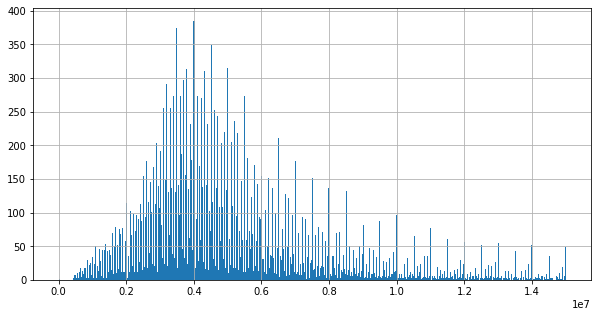

In [41]:
data.last_price.hist(bins = 500, range = (0, 15000000), figsize = (10, 5));

После преобразования гистограммы можно сделать вывод, что большинство объявлений находятся в промежутке до 8000000.

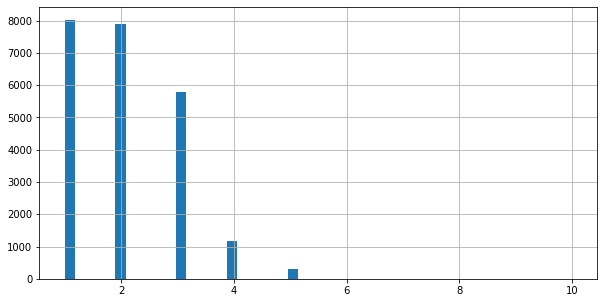

In [42]:
data.rooms.hist(bins = 50, range = (1, 10), figsize=(10,5));

Вывод по количествам комнат крайне логичный - большего всего 1-3 комнатных квартир, далее резкий спад.

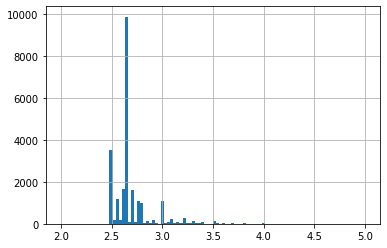

In [43]:
data.ceiling_height.hist(bins = 100, range = (2, 5));

Высота потолков логична - от 2.5 до 4 метров, с редкими исключеними.

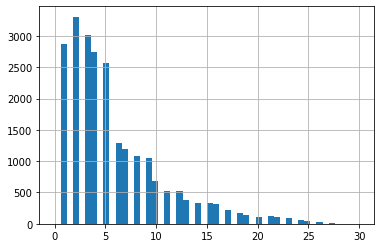

In [44]:
data.floor.hist(bins = 50, range = (0, 30));

Большая часть квартир расположена со 2 по 7 этаж.

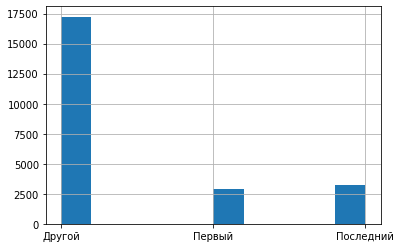

In [45]:
data.type_of_floor.hist();

Очевидно, что большая часть недвижемости расположена ни на первом, ни на последнем этаже.

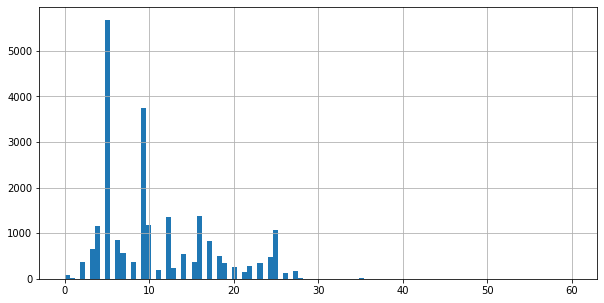

In [46]:
data.floors_total.hist(bins = 100, figsize = (10, 5));

Видно, что больше всего малоэтажных построек

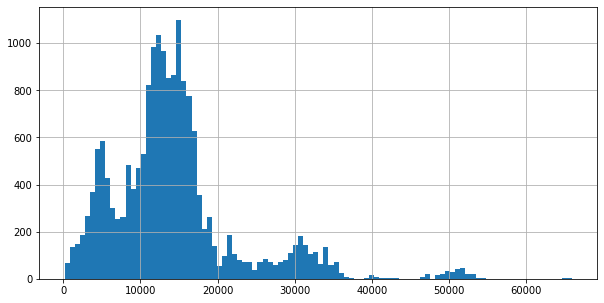

In [47]:
data.cityCenters_nearest.hist(bins = 100, figsize = (10, 5));

Большая часть квартир находится в пределах 28 км от центра города.

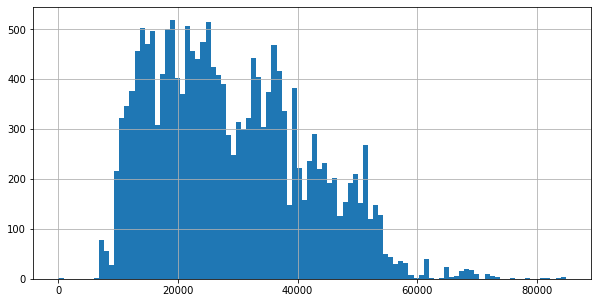

In [48]:
data.airports_nearest.hist(bins = 100, figsize = (10, 5));

В среднем от большинства квартир ехать до аэропорта около 40 км.

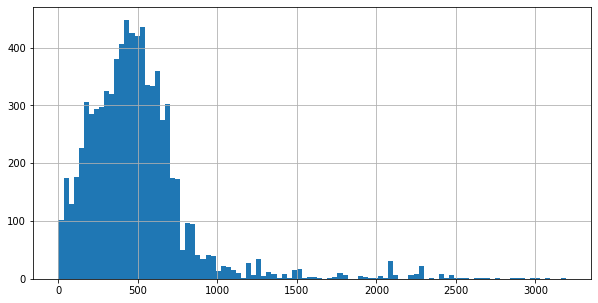

In [49]:
data.parks_nearest.hist(bins = 100, figsize = (10, 5));

Самое частое расстояние до парка среди продаваемых квартир 450 м.

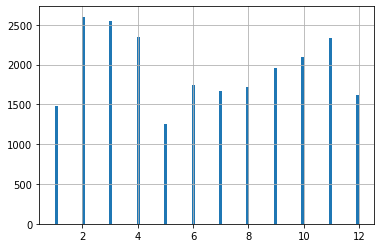

In [50]:
data.month.hist(bins = 100);

В начале года объявлений чуть больше.

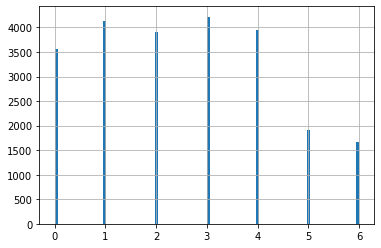

In [51]:
data.day_of_week.hist(bins = 100);

Все равномерно, четверг слегка лидирует)

#### Скорость продажи квартир.
Этот параметр показывает, сколько дней было размещено каждое объявление.

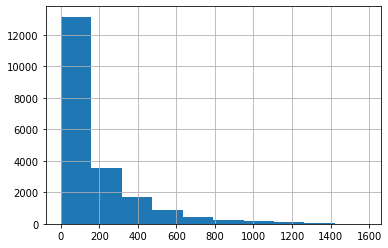

In [52]:
data['days_exposition'].hist()
plt.show()

In [53]:
data.days_exposition.mean()

179.9416613197769

In [54]:
data.days_exposition.median()

95.0

Основная часть продаж квартир происходит в период первого года, далее - спад. В промежутке до 170 дней - самая активная фаза продаж. Медиана составляет всего 74 дня.

#### Изучение факторов, которые больше всего влияют на общую (полную) стоимость объекта.

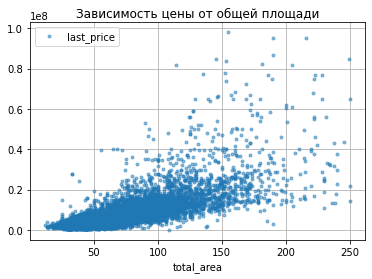

In [55]:
data.plot(x='total_area', y='last_price',\
                  style='.', title='Зависимость цены от общей площади',\
                  alpha=0.5, grid=True, sharex=False)
plt.show()

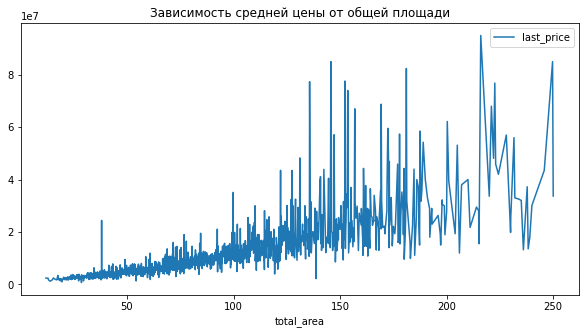

In [56]:
data.pivot_table(index='total_area', values='last_price')\
.plot(style='-',title='Зависимость средней цены от общей площади', figsize=(10, 5))
plt.show()

Есть сильная зависимость.

In [57]:
print('Коэффициент корреляции цены от общей площади', round(data['total_area'].corr(data['last_price']), 2))

Коэффициент корреляции цены от общей площади 0.74


Коэффициент корреляции цены от площади кухни 0.58


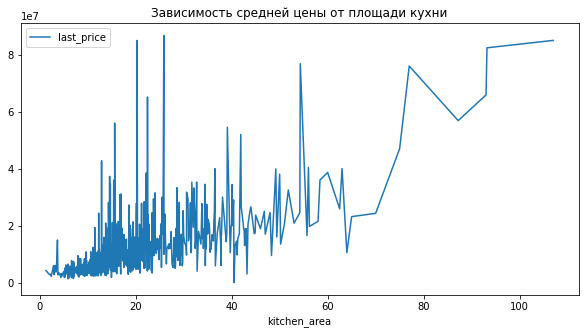

In [58]:
data.pivot_table(index='kitchen_area', values='last_price')\
.plot(style='-',title='Зависимость средней цены от площади кухни', figsize=(10, 5))
plt.show 
print('Коэффициент корреляции цены от площади кухни', round(data['kitchen_area'].corr(data['last_price']), 2))

Зависимость от площади кухни несильная.

Коэффициент корреляции цены от этажа 0.05


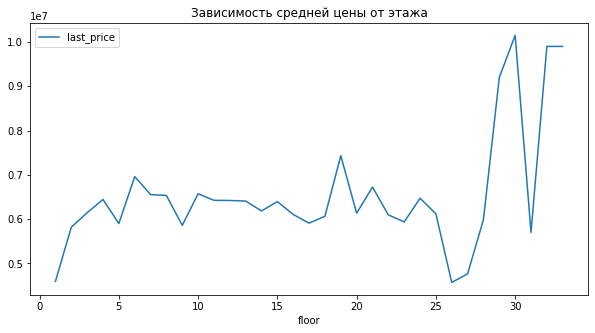

In [59]:
data.pivot_table(index='floor', values='last_price')\
.plot(style='-',title='Зависимость средней цены от этажа', figsize=(10, 5))
plt.show
print('Коэффициент корреляции цены от этажа', round(data['floor'].corr(data['last_price']), 2))

Пик на двадцатипятиэтажках.

Коэффициент корреляции цены от количества комнат 0.43


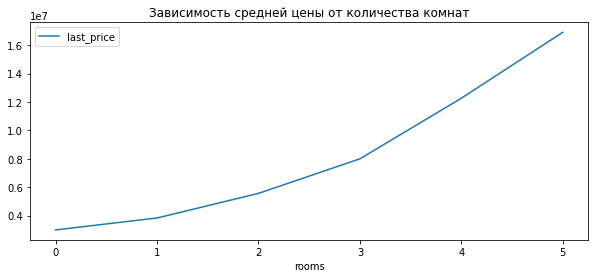

In [60]:
data.pivot_table(index='rooms', values='last_price')\
.plot(style='-',title='Зависимость средней цены от количества комнат', figsize=(10,4))
plt.show
print('Коэффициент корреляции цены от количества комнат', round(data['rooms'].corr(data['last_price']), 2))

Зависимость от количества комнат менее явная.

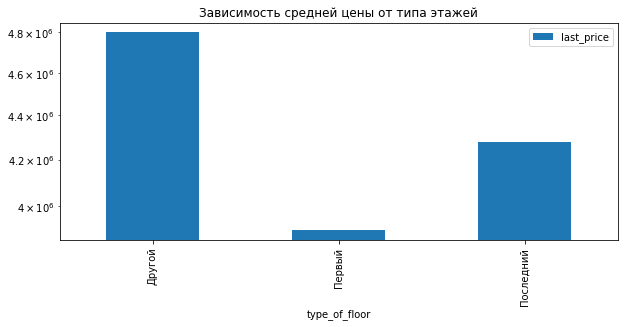

In [61]:
data.pivot_table(index='type_of_floor', values='last_price', aggfunc=('median'))\
.plot(style='-',title='Зависимость средней цены от типа этажей', figsize=(10,4), kind='bar', logy=True)
plt.show()

Анализ медианных значений показвает наиболее низкую стоимость квартир на первых этажах, а также снижение стоимости на последних этажах по сравнению с другими.

<function matplotlib.pyplot.show(close=None, block=None)>

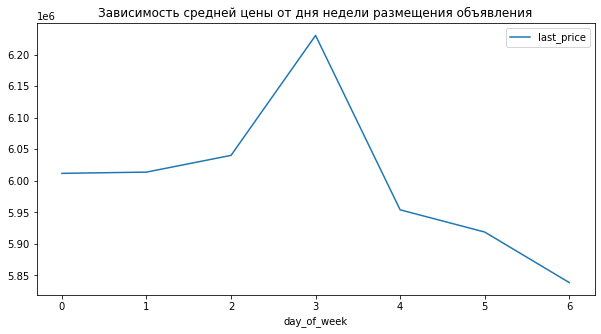

In [62]:
data.pivot_table(index='day_of_week', values='last_price')\
.plot(style='-',title='Зависимость средней цены от дня недели размещения объявления', figsize=(10, 5))
plt.show

Нулевая зависимость между ценой и днем размещения.

<function matplotlib.pyplot.show(close=None, block=None)>

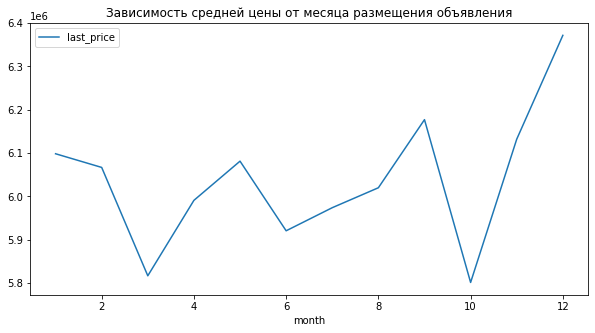

In [63]:
data.pivot_table(index='month', values='last_price')\
.plot(style='-',title='Зависимость средней цены от месяца размещения объявления', figsize=(10, 5))
plt.show

Нулевая зависимость между ценой и месяцем размещения.

<function matplotlib.pyplot.show(close=None, block=None)>

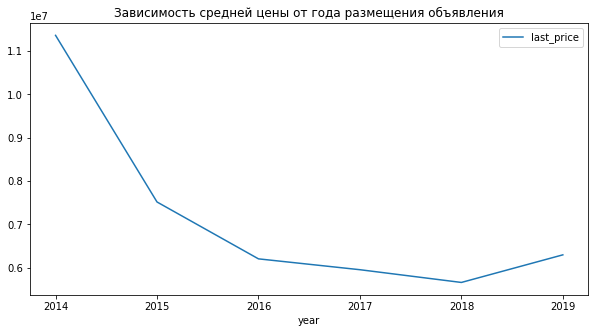

In [64]:
data.pivot_table(index='year', values='last_price')\
.plot(style='-',title='Зависимость средней цены от года размещения объявления', figsize=(10, 5))
plt.show

Коэффициент корреляции показывает отсутствие зависимости цены от года объявления.

#### Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [65]:
data.pivot_table(index='locality_name', values='last_price', aggfunc=['count', 'mean', 'median'])\
.sort_values(('count', 'last_price'), ascending=False)\
.head(10)\
.sort_values(('mean', 'last_price'), ascending=False)


,count,mean,median
,last_price,last_price,last_price
locality_name,,,
Санкт-Петербург,15433,7.309004e+06,5500000.0
Пушкин,363,6.308607e+06,5150000.0
Парголово,325,4.482463e+06,4100000.0
Кудрово,471,4.360299e+06,3890000.0
Шушары,440,4.108082e+06,3950000.0
Колпино,336,3.868569e+06,3600000.0
Всеволожск,397,3.792819e+06,3450000.0
Мурино,590,3.678462e+06,3400000.0


Из 10 городов с наибольшим количеством объявлений, максимальная средняя стоимость в Санкт-Петербурге, минимальная средняя стоимость в Выборге.

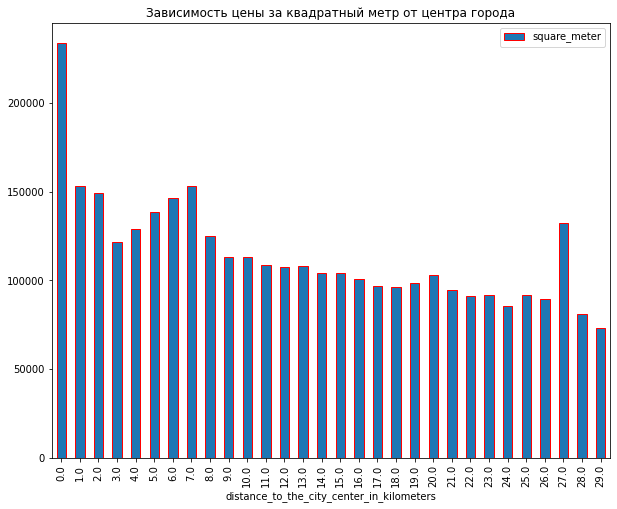

In [66]:
price_in_spb = data.query('locality_name == "Санкт-Петербург"')
price_in_spb = price_in_spb.pivot_table(index='distance_to_the_city_center_in_kilometers', values='square_meter')
(price_in_spb.plot(kind='bar', 
                   ec='red', 
                   figsize=(10,8), 
                   title='Зависимость цены за квадратный метр от центра города'));

Чем ближе к центру - тем выше цена.

### Общий вывод

Мы анализовали данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.

Что было сделано?

В шаге изучания информации:
- загрузжены данные из файла в датафрейм.
- построены общие гистограммы для всех числовых столбцов таблицы.

В шаге предобработки данных:
- определено в каких столбцах есть пропуски.
- заполнены пропущенные значения там, где это возможно.
- указаны причины, которые могли привести к пропускам в данных.
- изучены уникальные значения в столбце с названиями и устраните неявные дубликаты.
- найдите и устранены редкие и выбивающиеся значения.

В шаге добавления в таблицу новых столбцов со следующими параметрами:
- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

Исследовательский анализ данных показал:

Изучив параметры недвижимости, можно сделать вывод о наиболее продаваемом объекте недвижимости: это 1-2 комнатная квартира на 2-м - 7-м этаже с общей площадью 20-80 кв.м. с жилой площадью 12-22 кв.м. и площадью кухни около 10 кв.м., стоимостью 4 млн.руб. и высотой потолков от 2.5 до 4 метров, удаленная от центра на 12-16 км., от парка на 450 м и от аэропорта на 12-20 км.

Проведя анализ скорости продажи квартир, обнаружили, что среднее время продажи квартиры составляет 156 дней. Медианное значение составляет 74 дней, что сильно отличается от среднего. Чаще всего объекты продавались к 80 дню после подачи объявлений.

Изучив факторы, влияющие на стоимость объекта, выяснили что больше всего на стоимость влияет полная площадь квартир. Самая низкая цена у квартир на первом этаже, а выше всего цены на квартиры, находящиеся ни на первом, ни на последнем этаже. Увидели, что с 2014 года цены на квартиры падали, в 2018 году была самая низкая цена продаж, после чего цены вновь начали расти. 

Проанализировав стоимость объектов в зависимости от расстояния до центра в километрах убедились, что с приблежением к центру Санкт-Петербурга стоимость квадратного метра увеличивается.

После анализа цены одного квадратного метра, выяснили, что среди 10 населенных пунктов с наибольшим количеством объявлений максимальная стоимость квадратного метра наблюдается в Санкт-Петербурге, минимальная - в Выборге.
